# Building and testing GNNs

Inspiration found at https://github.com/deepfindr/gnn-project/blob/main/train.py

In [1]:
import torch
from torch import sigmoid
from torch.nn import Linear, BCEWithLogitsLoss
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import numpy as np

In [2]:
dataset = TUDataset(root='../data/', name='MUTAG')

In [3]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        embedding_size = 32
        
        #GCN Layers
        self.input = GCNConv(dataset.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.output = Linear(embedding_size*2, 1)
        
    def forward(self, x, edge_index, batch_index):
        out = self.input(x, edge_index)
        out = F.relu(out)
        out = self.conv1(out, edge_index)
        out = F.relu(out)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        out = F.relu(out)
        
        out = torch.cat([gmp(out, batch_index), gap(out, batch_index)], dim=1)
        
        out = self.output(out)
        
        return out

In [4]:
class GAT(torch.nn.Module):
    def __init__(self, feature_size):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        num_heads = 3
        embedding_size = 32
        
        #GAT layers
        self.input = GATConv(feature_size, embedding_size, heads=num_heads, dropout=0.3)
        self.conv1 = GATConv(embedding_size, embedding_size, heads=num_heads, dropout=0.3)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=num_heads, dropout=0.3)
        
        # Tranformer layers
        self.head_transform = Linear(embedding_size*num_heads, embedding_size)
        
        # Pooling layers
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)
        
        # Linear layers
        self.linear1 = Linear(embedding_size*2, embedding_size)
        self.output = Linear(embedding_size, 1)
        
    def forward(self, x, edge_index, batch_index):
        out = self.input(x, edge_index)
        out = self.head_transform(out)
        out, edge_index, edge_attr, batch_index, _, _ = self.pool1(out, edge_index, None, batch_index)
        
        out1 = torch.cat([gmp(out, batch_index), gap(out, batch_index)], dim=1)
        
        out = self.conv1(out, edge_index)
        out = self.head_transform(out)
        out, edge_index, edge_attr, batch_index, _, _ = self.pool2(out, edge_index, None, batch_index)
        
        out2 = torch.cat([gmp(out, batch_index), gap(out, batch_index)], dim=1)
        
        out = self.conv2(out, edge_index)
        out = self.head_transform(out)
        out, edge_index, edge_attr, batch_index, _, _ = self.pool3(out, edge_index, None, batch_index)
        
        out3 = torch.cat([gmp(out, batch_index), gap(out, batch_index)], dim=1)
        
        out = out1 + out2 + out3
        
        out = self.linear1(out).relu()
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.output(out)
        
        return out

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
#model = GCN()
model = GAT(dataset.num_features)
print(model)
print(f'Number of parameters: {count_parameters(model)}')

GAT(
  (input): GATConv(7, 32, heads=3)
  (conv1): GATConv(32, 32, heads=3)
  (conv2): GATConv(32, 32, heads=3)
  (head_transform): Linear(in_features=96, out_features=32, bias=True)
  (pool1): TopKPooling(32, ratio=0.8, multiplier=1.0)
  (pool2): TopKPooling(32, ratio=0.5, multiplier=1.0)
  (pool3): TopKPooling(32, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)
Number of parameters: 12993


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = torch.tensor([1.0], dtype=torch.float32).to(device)
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)
model = model.to(device)

GRAPH_BATCH_SIZE = 16
train_loader = DataLoader(dataset[:int(len(dataset)*0.8)], batch_size=GRAPH_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset[int(len(dataset)*0.8):], batch_size=GRAPH_BATCH_SIZE, shuffle=True)

In [13]:
def train_model(data):
    step = 0
    running_loss = 0.0
    y_pred, y_true = [], []
    for batch in data:
        batch.to(device)
        optimizer.zero_grad()
        predictions = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(torch.squeeze(predictions), batch.y.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step += 1
        
        y_pred.append(np.rint(torch.round(sigmoid(predictions)).detach().cpu().numpy()))
        y_true.append(batch.y.detach().cpu().numpy())
    
    y_pred = np.concatenate(y_pred).ravel()
    y_true = np.concatenate(y_true).ravel()
    
    return running_loss/step, y_pred, y_true

In [14]:
def test_model(data):
    step = 0
    running_loss = 0.0
    y_pred, y_true = [], []
    for batch in data:
        batch.to(device)
        predictions = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(torch.squeeze(predictions), batch.y.float())
        running_loss += loss.item()
        step += 1
        y_pred.append(np.rint(torch.round(sigmoid(predictions)).detach().cpu().numpy()))
        y_true.append(batch.y.detach().cpu().numpy())
        
    y_pred = np.concatenate(y_pred).ravel()
    y_true = np.concatenate(y_true).ravel()
    
    return running_loss/step, y_pred, y_true

In [15]:
for epoch in range(1, 101):
    model.train()
    train_loss, train_y_pred, train_y_true = train_model(train_loader)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.3f}")
        
        model.eval()
        test_loss, test_y_pred, test_y_true = test_model(test_loader)
        print(f"Epoch {epoch} | Test Loss: {test_loss:.3f}")
        
    #scheduler.step()

Epoch 1 | Train Loss: 0.664
Epoch 1 | Test Loss: 0.582
Epoch 10 | Train Loss: 0.667
Epoch 10 | Test Loss: 0.672
Epoch 20 | Train Loss: 0.554
Epoch 20 | Test Loss: 0.599
Epoch 30 | Train Loss: 0.563
Epoch 30 | Test Loss: 0.635
Epoch 40 | Train Loss: 0.557
Epoch 40 | Test Loss: 0.612
Epoch 50 | Train Loss: 0.515
Epoch 50 | Test Loss: 0.542
Epoch 60 | Train Loss: 0.547
Epoch 60 | Test Loss: 0.574
Epoch 70 | Train Loss: 0.560
Epoch 70 | Test Loss: 0.559
Epoch 80 | Train Loss: 0.521
Epoch 80 | Test Loss: 0.528
Epoch 90 | Train Loss: 157.427
Epoch 90 | Test Loss: 665.043
Epoch 100 | Train Loss: 109.866
Epoch 100 | Test Loss: 0.603


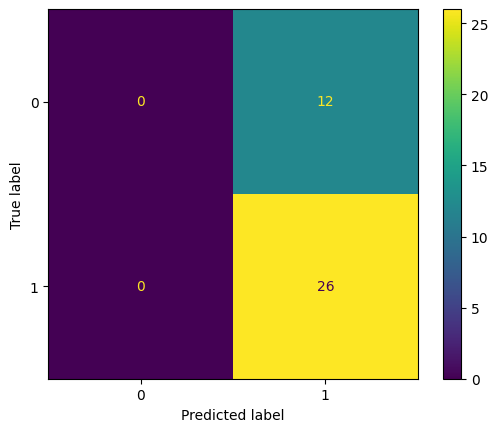

In [16]:
cm = confusion_matrix(test_y_true, test_y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()